# Task 5.2HD - Minor research project
**Demonstration**

The following notebook contains the code and demonstration for SIT789 Task 5.2HD “minor research project”. The chosen paper was [*Multi-Metric Optimization using Generative Adversarial Networks for Near-End Speech Intelligibility Enhancement*](https://arxiv.org/pdf/2104.08499.pdf) on the topic of speech intelligibility enhancement.

For the associated report and discussion, please see the attached pdf document.

**Table of contents**     
- Set-up    
- Import Modules    
- Data Preparation    
  - Data sourcing    
  - Generate pre-enhanced samples for training    
  - Data processing    
- Model Training    
  - Prepare training parameters    
  - Run training steps    
- Model Testing    
  - Generate enhanced speech on test data    
  - Test on the different enhanced signals    
  - Generate demonstration samples    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=false
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

---

# Set-up

Note the current notebook is being run on a Google Cloud VM. This is due to the requirement for CUDA (GPU) in the original papers model. The specifications have been chosen to be compatible with the software versions specified in https://github.com/nii-yamagishilab/NELE-GAN/tree/master

The specifications of the VM are:
| Property | Value |
| -- | -- |
| Machine Type | n1-standard-4 |
| Operating System| Debian 10 |
| CPU Platform | Intel Broadwell |
| CPU | 4 vCPU 16Gb RAM |
| GPU | 1 x NVIDIA T4 |

The following code is used to set-up the environment to mimic the original paper and install all dependencies.

In [1]:
# Check the python version
!python -V

Python 3.7.12


In [ ]:
!pip install librosa==0.7.1 numpy==1.17.2 numba==0.48 matplotlib==3.1.1 pandas==1.0.0 --force-reinstall

In [ ]:
# Install requirements for Intelligibility and Quality metrics
!pip install git+https://github.com/kamo-naoyuki/pySIIB.git
!pip install pystoi
!pip install pypesq

In [3]:
# Must manually build the VISQOL metric
!git clone https://github.com/google/visqol.git

Cloning into 'visqol'...
remote: Enumerating objects: 728, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 728 (delta 155), reused 164 (delta 131), pack-reused 500
Receiving objects: 100% (728/728), 68.21 MiB | 15.28 MiB/s, done.
Resolving deltas: 100% (410/410), done.


In [1]:
# Once bazel is installed as per visqol README run the following in the command line under the visqol directory
# Note you must set you python path correctly
# NOTE: Had to change line 54 of .bazelrc from `build --linkopt=-ldl` to `build --linkopt=-lstdc++fs`
!bazel build :visqol -c opt --action_env PYTHON_BIN_PATH="/opt/conda/bin/python"

In [2]:
# Clone the NELE-GAN repository
!git clone https://github.com/nii-yamagishilab/NELE-GAN.git

Cloning into 'NELE-GAN'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 131 (delta 52), reused 62 (delta 11), pack-reused 0
Receiving objects: 100% (131/131), 10.52 MiB | 17.44 MiB/s, done.
Resolving deltas: 100% (52/52), done.


# Import Modules

In [40]:
import os
import glob
import random
import shutil

import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from matplotlib.image import imread

import torch
import torch.nn as nn
from NELE_GAN.audio_util import *
from pystoi.stoi import stoi
from NELE_GAN.model import Generator_Conv1D_cLN, Discriminator, Discriminator_Quality
from NELE_GAN.dataloader import *

from tqdm import tqdm
import soundfile as sf

# Data Preparation

In this section we will source and prepare the data to be used for training and testing the model. The speech samples required are
- Clean speech signals
- Noise signals

Each clean speech sample will be combined with a noise sample, and split into training, validation, and test datasets.

The training signals will also be used to train a reference algorithm as per the original paper.

The original model was trained on 1200 clean sentences (600 x 2 genders).

## Data sourcing

The clean data set will be based off the *development* version of the LibriSpeech ASR corpus found [here](https://www.openslr.org/12).

>Panayotov, V., Chen, G., Povey, D. and Khudanpur, S., 2015, April. Librispeech: an asr corpus based on public domain audio books. In 2015 IEEE international conference on acoustics, speech and signal processing (ICASSP) (pp. 5206-5210). IEEE.

In [2]:
# Download the dataset
!mkdir -p source-data
!wget -c --tries=0 --read-timeout=20 http://www.openslr.org/resources/12/dev-clean.tar.gz -P source-data
!tar -xzf source-data/dev-clean.tar.gz -C source-data
!rm -rf source-data/dev-clean.tar.gz

--2023-09-26 01:59:53--  http://www.openslr.org/resources/12/dev-clean.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://us.openslr.org/resources/12/dev-clean.tar.gz [following]
--2023-09-26 01:59:54--  https://us.openslr.org/resources/12/dev-clean.tar.gz
Resolving us.openslr.org (us.openslr.org)... 46.101.158.64
Connecting to us.openslr.org (us.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 337926286 (322M) [application/x-gzip]
Saving to: ‘source-data/dev-clean.tar.gz’

dev-clean.tar.gz    100%[===================>] 322.27M  11.0MB/s    in 32s     

2023-09-26 02:00:26 (10.2 MB/s) - ‘source-data/dev-clean.tar.gz’ saved [337926286/337926286]



In [4]:
number_audio_files = sum([len(files) for r, d, files in os.walk("source-data/LibriSpeech/dev-clean/")])
print(f"The number of audio files in the source data is: {number_audio_files}")

The number of audio files in the source data is: 2800


This gives us slightly more clean audio samples than what was used in the original paper.

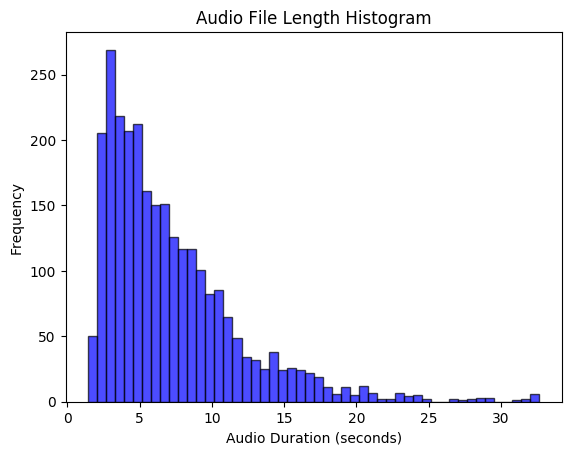

In [6]:
# Display the distribution of lengths of the audio samples
# Function to get audio file lengths
def get_audio_lengths(root_dir):
    audio_lengths = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('.wav', '.mp3', '.flac')):
                file_path = os.path.join(subdir, file)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    duration = librosa.get_duration(y=y, sr=sr)
                    audio_lengths.append(duration)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

    return audio_lengths

root_directory = "./source-data/LibriSpeech/dev-clean/"
audio_lengths = get_audio_lengths(root_directory)
# Create a histogram
plt.hist(audio_lengths, bins=50, alpha=0.7, color='b', edgecolor='black')
plt.xlabel("Audio Duration (seconds)")
plt.ylabel("Frequency")
plt.title("Audio File Length Histogram")
plt.show()

Next we will source the noise samples to be used.

Like the original paper, we will source our noise samples from the [MS-SNSD](https://github.com/microsoft/MS-SNSD/tree/master) dataset however we will chose 6 different noise types than those chosen in the original paper.

>Reddy, C.K., Beyrami, E., Pool, J., Cutler, R., Srinivasan, S. and Gehrke, J., 2019. A scalable noisy speech dataset and online subjective test framework. arXiv preprint arXiv:1909.08050.

In [7]:
# Clone the repository
!git clone https://github.com/microsoft/MS-SNSD.git

Cloning into 'MS-SNSD'...
remote: Enumerating objects: 29924, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 29924 (delta 2), reused 0 (delta 0), pack-reused 29915
Receiving objects: 100% (29924/29924), 3.93 GiB | 19.35 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Checking out files: 100% (24399/24399), done.


In [11]:
# Define the directories to search for .wav files
directories = ["MS-SNSD/noise_test", "MS-SNSD/noise_train"]

# Initialize a set to store unique noise types
unique_noise_types = set()

# Loop through directories
for directory in directories:
    # Use glob to get a list of .wav files in the directory
    wav_files = glob.glob(os.path.join(directory, "*.wav"))
    
    # Loop through .wav files and extract noise types
    for wav_file in wav_files:
        file_name = os.path.basename(wav_file)
        # Split the file name by '_' and get the noise type
        noise_type = file_name.split('_')[0]
        unique_noise_types.add(noise_type)

# Convert the set to a sorted list of unique noise types
unique_noise_types_list = sorted(list(unique_noise_types))

# Print the list of unique noise types
print(f"Unique Noise Types: {', '.join(unique_noise_types_list)}")

Unique Noise Types: AirConditioner, AirportAnnouncement, AirportAnnouncements, Babble, Bus, Cafe, CafeTeria, Car, CopyMachine, Field, Hallway, Kitchen, LivingRoom, Metro, Munching, Neighbor, NeighborSpeaking, Office, Park, Restaurant, ShuttingDoor, Square, SqueakyChair, Station, Traffic, Typing, VacuumCleaner, WasherDryer, Washing


## Generate pre-enhanced samples for training

As mentioned in the original paper, pre-enhanced training samples from an existing near-end speech enhancement algorithm can stabilise the training process.

In this implementation we will generate pre-enhanced training samples with the wSSDRC model presented in [Shifas, Tsiaras, and Stylianou (2018)](https://pdfs.semanticscholar.org/0b7f/7d4ac60b3368920573d140fdd4f986c938e6.pdf). Which is an enhancement of the SSDRC model.

The model used is pre-trained according to the paper and sourced from https://github.com/shifaspv/wSSDRC-tesnorflow-implementation/tree/master.

>Muhammed Shifas, P.V., Tsiaras, V. and Stylianou, Y., 2018. Speech intelligibility enhancement based on a non-causal Wavenet-like model. In Proc. Interspeech (Vol. 2018, pp. 1868-1872).

In [10]:
# Clone the repository containing the model
!git clone https://github.com/shifaspv/wSSDRC-tesnorflow-implementation.git

Cloning into 'wSSDRC-tesnorflow-implementation'...
remote: Enumerating objects: 123, done.
remote: Total 123 (delta 0), reused 0 (delta 0), pack-reused 123
Receiving objects: 100% (123/123), 1.15 MiB | 16.41 MiB/s, done.
Resolving deltas: 100% (40/40), done.


Inside the repository, the configuration was changed as follows:
- wavenet-11.data-00000-of-00001, wavenet-11.index, and wavenet-11.meta were manually downloaded from previous commits (the latest checkpoint 14 was not avaliable)
- `data_dir` in [wSSDRC-tesnorflow-implementation/config/config_params.json](wSSDRC-tesnorflow-implementation/config/config_params.json) was changed to `""`
- `base_dir` in [wSSDRC-tesnorflow-implementation/config/config_params.json](wSSDRC-tesnorflow-implementation/config/config_params.json) was changed to `./wSSDRC-tesnorflow-implementation`
- `audio_ext` in [wSSDRC-tesnorflow-implementation/config/config_params.json](wSSDRC-tesnorflow-implementation/config/config_params.json) `.flac`
- `test_noisy_audio_dir` in [wSSDRC-tesnorflow-implementation/config/config_params.json](wSSDRC-tesnorflow-implementation/config/config_params.json) was changed to `""`
- `wav_out_path` on Line 44 of [wSSDRC-tesnorflow-implementation/src/generate.py](wSSDRC-tesnorflow-implementation/src/generate.py) was changed to `cfg['output_dir']`
-  `clean_audio_out_fullpathname` on Line 48 of [wSSDRC-tesnorflow-implementation/src/generate.py](wSSDRC-tesnorflow-implementation/src/generate.py) was changed to `os.path.join(wav_out_path, cfg['output_clean_speech_filename'].split("/")[-1] + cfg['audio_ext'])`
- `output_dir` in [wSSDRC-tesnorflow-implementation/config/config_params.json](wSSDRC-tesnorflow-implementation/config/config_params.json) was changed to `./enhanced-data/wSSDRC/`
- `'clean_' + ` was removed from Line 54 of [wSSDRC-tesnorflow-implementation/src/model_io.py](wSSDRC-tesnorflow-implementation/src/model_io.py)

In [ ]:
%%bash
# Generate the enhanced samples by calling the model's generate.py for every training sample WARNING LONG RUNNING OPERATION
filenames=$(find source-data/LibriSpeech/dev-clean/ -type f -name "*.flac" | sed -e 's/\.flac$//')
for filename in $filenames
do
    echo $filename
    python ./wSSDRC-tesnorflow-implementation/src/generate.py --config=config_params.json --model_id=1 --noisy_speech_filename=$filename
done

## Data processing

In this section we will split the data into train, validation, and test splits as well as generate the noise for each audio sample of the correct length and signal to noise ratio.

These samples will be placed into a directory structure which is expected by the NELE-GAN model. That is:
```
├── Test
│   ├── Clean
│   │   ├── sample_name#noise_type#SNR.wav
│   ├── Noise
│   │   ├── sample_name#noise_type#SNR.wav
├── Train
│   ├── Clean
│   │   ├── sample_name2#noise_type#SNR.wav
│   ├── MultiEnh
│   │   ├── sample_name2#noise_type#SNR.wav
│   ├── Noise
└── └── └── sample_name2#noise_type#SNR.wav
```


In [3]:
# Define some helper functions that will help generate the noise files

def snr_mixer(clean, noise, snr):
    # Normalizing to -25 dB FS
    rmsclean = (clean**2).mean()**0.5
    scalarclean = 10 ** (-25 / 20) / rmsclean
    clean = clean * scalarclean
    rmsclean = (clean**2).mean()**0.5

    rmsnoise = (noise**2).mean()**0.5
    scalarnoise = 10 ** (-25 / 20) /rmsnoise
    noise = noise * scalarnoise
    rmsnoise = (noise**2).mean()**0.5
    
    # Set the noise level for a given SNR
    noisescalar = np.sqrt(rmsclean / (10**(snr/20)) / rmsnoise)
    noisenewlevel = noise * noisescalar
    
    # return noise that is the same length as clean signal (NELE-GAN code does not check this)
    if len(noisenewlevel) > len(clean):
        # Truncate noisenewlevel if it is longer than clean
        noisenewlevel = noisenewlevel[:len(clean)]
    else:
        # Repeat noisenewlevel to match the length of clean using numpy broadcasting
        repetitions = -(-len(clean) // len(noisenewlevel))  # Calculate how many times to repeat noisenewlevel
        noisenewlevel = np.tile(noisenewlevel, repetitions)[:len(clean)]  # Repeat noisenewlevel and truncate to the desired length
    
    assert len(noisenewlevel)==len(clean), f"Length of noise is {len(noisenewlevel)} but length of clean is {len(clean)}"
    return clean, noisenewlevel

eps = 1e-4
# Function to read audio
def audioread(path, norm = True, start=0, stop=None):
    path = os.path.abspath(path)
    if not os.path.exists(path):
        raise ValueError("[{}] does not exist!".format(path))
    try:
        x, sr = sf.read(path, start=start, stop=stop)
    except RuntimeError:  # fix for sph pcm-embedded shortened v2
        print('WARNING: Audio type not supported')

    if len(x.shape) == 1:  # mono
        if norm:
            rms = (x ** 2).mean() ** 0.5
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    else:  # multi-channel
        x = x.T
        x = x.sum(axis=0)/x.shape[0]
        if norm:
            rms = (x ** 2).mean() ** 0.5
            scalar = 10 ** (-25 / 20) / (rms)
            x = x * scalar
        return x, sr
    
# Funtion to write audio    
def audiowrite(data, fs, destpath, norm=False):
    if norm:
        rms = (data ** 2).mean() ** 0.5
        scalar = 10 ** (-25 / 10) / (rms+eps)
        data = data * scalar
        if max(abs(data))>=1:
            data = data/max(abs(data), eps)
    
    destpath = os.path.abspath(destpath)
    destdir = os.path.dirname(destpath)
    
    if not os.path.exists(destdir):
        os.makedirs(destdir)
    
    sf.write(destpath, data, fs)
    return

In [4]:
def get_all_files_in_directory(root_directory):
    file_list = []

    for root, _, files in os.walk(root_directory):
        for file in files:
            if file.endswith(('.wav', '.mp3', '.flac')):
                file_path = os.path.join(root, file)
                file_list.append(file_path)

    return file_list

clean_signals = get_all_files_in_directory('source-data/LibriSpeech/dev-clean/')
# Randomly shuffle the file paths
random.shuffle(clean_signals)

In [5]:
# Store the configuration in a dictionary
splits_config = {
    "Train": {
        "Size": 0.8,
        "NoiseTypes": ["AirConditioner","NeighborSpeaking", "Munching", "Typing"]
    },
    "Validation": {
        "Size": 0.1,
        "NoiseTypes": ["AirConditioner","NeighborSpeaking", "Munching", "Typing"]
    },
    "Test": {
        "Size": 0.1,
        "NoiseTypes": ["Cafe","VacuumCleaner"]
    }
}

# Define the SNR levels for each noise, values replicated from original paper
noise_snr_config = {
    "AirConditioner":[-11,-7,-3],
    "NeighborSpeaking":[-11,-7,-3],
    "Munching":[-11,-7,-3],
    "Typing":[-11,-7,-3],
    "Cafe":[-9,-5,-1],
    "VacuumCleaner":[-13,-9,-5],
}

In [6]:
# Now write files to expected structure

root_dir = "data"

train_split_size = int(splits_config["Train"]["Size"] * len(clean_signals))
val_split_size = int(splits_config["Validation"]["Size"] * len(clean_signals))
test_split_size = int(splits_config["Test"]["Size"] * len(clean_signals))

train_files = clean_signals[:train_split_size]
val_files = clean_signals[train_split_size:train_split_size + val_split_size]
test_files = clean_signals[train_split_size + val_split_size:]

splits_config["Train"]["Files"] = train_files
splits_config["Validation"]["Files"] = val_files
splits_config["Test"]["Files"] = test_files

# For each split
for split, config in splits_config.items():
    print(f"Generating {split} data...")
    # For each file in the list of files
    for speech_file in config["Files"]:
        # Read the clean file
        speech, speech_sr = audioread(speech_file)
        speech_file_noext = speech_file.split("/")[-1].split(".")[0]
        # Load the corresponding enhanced speech data. This will have the added benefit on normalising the volume
        enhanced_speech, enhanced_speech_sr = audioread(os.path.join("enhanced-data","wSSDRC",speech_file_noext+".flac"))
        # For each noise type configured for the split
        for noise_type in config["NoiseTypes"]:
            # Find all the files which match that noise type
            matching_noise_patterns = glob.glob(f"MS-SNSD/noise_*/{noise_type}*")
            # Randomly choose one of the matching noise files
            noise_file = random.choice(matching_noise_patterns)
            noise, noise_sr = audioread(noise_file)
            # For each SNR value for that particular noise type
            for snr in noise_snr_config[noise_type]:
                clean, newnoise = snr_mixer(speech, noise, snr)
                # Finally, write the files to the required folder
                clean_dir = os.path.join(root_dir, split, "Clean", f"{speech_file_noext}#{noise_type}#{snr}.wav")
                audiowrite(clean, speech_sr, clean_dir)
                enhanced_dir = os.path.join(root_dir, split, "MultiEnh", f"{speech_file_noext}#{noise_type}#{snr}.wav")
                audiowrite(enhanced_speech, enhanced_speech_sr, enhanced_dir)
                noise_dir = os.path.join(root_dir, split, "Noise", f"{speech_file_noext}#{noise_type}#{snr}.wav")
                audiowrite(newnoise, noise_sr, noise_dir)

Generating Train data...


Generating Validation data...
Generating Test data...


In [7]:
number_train_files = sum([len(files) for r, d, files in os.walk("data/Train/Clean/")])
print(f"The number training samples is: {number_train_files}")

number_validation_files = sum([len(files) for r, d, files in os.walk("data/Validation/Clean/")])
print(f"The number validation samples is: {number_validation_files}")

number_test_files = sum([len(files) for r, d, files in os.walk("data/Test/Clean/")])
print(f"The number testing samples is: {number_test_files}")

The number training samples is: 25944
The number validation samples is: 3240
The number testing samples is: 1626


# Model Training

The following section trains the NELE-GAN model on the data prepared above. The code used is adapted from the `train_nele.py` script in the initial repository.

Please note the following changes were made to the NELE-GAN source code to adapt to the new data:
- On lines 234 and 342 of `audio_util.py`:
```diff 
- program = '/home/smg/haoyuli/repos/visqol/bin/visqol' # visqol exec program
- model_path = '/home/smg/haoyuli/repos/visqol/model/libsvm_nu_svr_model.txt' # visqol model path
+ program = 'visqol/bazel-bin/visqol' # visqol exec program
+ model_path = 'visqol/model/lattice_tcditugenmeetpackhref_ls2_nl60_lr12_bs2048_learn.005_ep2400_train1_7_raw.tflite' # visqol model path
```
note that the tf lite model must be used when --speech-mode is specified for visqol.
- Just in time compiling (@jit) was removed from the pyhaspi2 implementation.

- The directory name was changed to NELE_GAN to support imports.

- `.` added in front of importing modules to support relative imports

- Change the n_jobs in `Parallel` to -1 to ensure all available core are utilised during batch metric calculations.

- Additionally the size of the GCP VM has been increased to support the parallel processing when loading the files and calculating the performance metrics.

- Lastly, the noise estimation code has been changed to add a small perturbabtion to the STFT of the signal. This is to avoid divide by 0 errors which were occurring during training. i.e. `Y = Y+1e-8`

## Prepare training parameters

In [3]:
# Set up training parameters
output_path='./output'
pt_dir = './chkpt'
#GAN_epoch = 500
GAN_epoch = 50
num_of_sampling = 100 # 100, in each epoch randonly sample only 100 for training to speed up
num_of_valid_sample = 50 # number of validation audio
batch_size = 1
fs = 16000 # sampling rate
p_power = (1/6) # power-law compression
inv_p = 6 # inverse of p_power

weight_qua = 0.5 # weight controlling quality item, given in Eq.(7)

creatdir(pt_dir)
creatdir(output_path)

import matplotlib
matplotlib.use('Agg')

In [4]:
# Configure train data paths
Train_Noise_path = 'data/Train/Noise/'
Train_Clean_path = 'data/Train/Clean/'
Train_Enhan_path = 'data/Train/MultiEnh/' # contains pre-enhanced speech examples y_hat shown in Eqs.(5) and (6). In our paper, we use SSDRC to generate them
Generator_Train_paths = get_filepaths('data/Train/Clean')
# Data_shuffle
random.shuffle(Generator_Train_paths)

# Configure validation data paths
Test_Noise_path ='data/Validation/Noise/'
Test_Clean_path = 'data/Validation/Clean/'
Generator_Test_paths = get_filepaths('data/Validation/Clean/') 
# Data_shuffle
random.shuffle(Generator_Test_paths)


In [5]:
# Load the models
G = Generator_Conv1D_cLN().cuda()
D = Discriminator().cuda()
D_Qua = Discriminator_Quality().cuda()

# Load the training losses
MSELoss = nn.MSELoss().cuda()
optimizer_g = torch.optim.Adam(G.parameters(), lr=5e-4)
optimizer_d = torch.optim.Adam(D.parameters(), lr=2.5e-4)
optimizer_dqua = torch.optim.Adam(D_Qua.parameters(), lr=2.5e-4)

## Run training steps

In [ ]:
Test_HASPI = []
Test_ESTOI = []
Test_SIIB = []
Test_PESQ = []
Test_VISQOL = []

Previous_Discriminator_training_list = []
shutil.rmtree(output_path)

step_g = 0
step_d = 0

cuda_device = '0'
os.environ["CUDA_VISIBLE_DEVICES"] = cuda_device

try:
	for gan_epoch in np.arange(1, GAN_epoch+1):

		# Prepare directories
		creatdir(output_path+"/epoch"+str(gan_epoch))
		creatdir(output_path+"/epoch"+str(gan_epoch)+"/"+"Test_epoch"+str(gan_epoch))
		creatdir(output_path+'/For_discriminator_training')
		creatdir(output_path+'/temp')

		# random sample some training data  
		random.shuffle(Generator_Train_paths)
		genloader = create_dataloader(Generator_Train_paths[0:round(1*num_of_sampling)],Train_Noise_path)

		if gan_epoch>=2:
			print('Generator training (with discriminator fixed)...')
			for clean_band, clean_mag, clean_phase, noise_band, noise_mag, noise_phase, target, target_qua, filename in tqdm(genloader):
				clean_band = clean_band.cuda()
				noise_band = noise_band.cuda()
				target = target.cuda()
				target_qua = target_qua.cuda()

				mask = G(clean_band, noise_band) # outout mask is actually alpha^2 shown in paper, which should be applied to power spectrum 

				# Do utterance-level energy normalization
				clean_power = torch.pow(clean_band.detach(), inv_p)
				beta_2 = torch.sum(clean_power) / torch.sum(mask*clean_power)
				beta_p = beta_2 ** p_power

				enh_band = clean_band * torch.pow(mask, p_power) * beta_p
				ref_band = clean_band.detach()

				enh_band = enh_band.view(1,1,enh_band.shape[1],enh_band.shape[2]).transpose(2,3).contiguous()
				noise_band = noise_band.view(1,1,noise_band.shape[1],noise_band.shape[2]).transpose(2,3).contiguous()
				ref_band = ref_band.view(1,1,ref_band.shape[1],ref_band.shape[2]).transpose(2,3).contiguous()
				d_inputs = torch.cat((enh_band,noise_band,ref_band),dim=1)
				d_inputs_qua = torch.cat((enh_band, ref_band),dim=1)

				score = D(d_inputs)
				score_qua = D_Qua(d_inputs_qua)

				loss = MSELoss(score, target) + weight_qua * MSELoss(score_qua, target_qua)
				optimizer_g.zero_grad()
				loss.backward()
				optimizer_g.step()
				step_g += 1


		# Evaluate the performance of generator in a validation set.
		interval_epoch = 1
		if gan_epoch % interval_epoch == 0: 
			print('Evaluate G by validation data ...')
			Test_enhanced_Name = []
			utterance = 0
			G.eval()
			with torch.no_grad():
				for i, path in enumerate(Generator_Test_paths[0:num_of_valid_sample]):
					S = path.split('/')
					wave_name = S[-1]

					clean_wav,sr = librosa.load(path, sr=None)
					assert sr==16000
					noise_wav,sr = librosa.load(Test_Noise_path+wave_name, sr=None)
					assert sr==16000

					clean_band, clean_mag, clean_phase = Sp_and_phase_Speech(clean_wav, power=p_power, Normalization=True)
					noise_band, noise_mag, noise_phase = Sp_and_phase_Noise(noise_wav, power=p_power, Normalization=True)
					
					clean_in = clean_band.reshape(1,clean_band.shape[0],-1)
					clean_in = torch.from_numpy(clean_in).cuda()
					noise_in = noise_band.reshape(1,noise_band.shape[0],-1)
					noise_in = torch.from_numpy(noise_in).cuda()

					mask = G(clean_in, noise_in)
					clean_power = torch.pow(clean_in, inv_p)
					beta_2 = torch.sum(clean_power) / torch.sum(mask*clean_power)
					# beta_2 = torch.sum(clean_power, dim=2) / torch.sum(mask*clean_power, dim=2)
					# beta_2 = beta_2.unsqueeze(2)
					mask = mask * beta_2 # normed alpha2
					mask = mask.detach().cpu().squeeze(0).numpy()
					enh_wav = SP_to_wav(mask, clean_mag, clean_phase)

					if utterance<20: # Only seperatly save the firt 20 utterance for listening comparision 
						enhanced_name=output_path+"/epoch"+str(gan_epoch)+"/"+"Test_epoch"+str(gan_epoch)+"/"+ wave_name[0:-4]+"@"+str(gan_epoch)+wave_name[-4:]
					else:
						enhanced_name=output_path+"/temp"+"/"+ wave_name[0:-4]+"@"+str(gan_epoch)+wave_name[-4:]
				
					sf.write(enhanced_name, enh_wav, fs,'PCM_16')
					utterance+=1      
					Test_enhanced_Name.append(enhanced_name) 
					#print(i)
			G.train()

			# Calculate True HASPI
			test_HASPI = read_batch_HASPI(Test_Clean_path, Test_Noise_path, Test_enhanced_Name, norm=False)
			Test_HASPI.append(np.mean(test_HASPI))

			# Calculate True ESTOI
			test_ESTOI = read_batch_STOI(Test_Clean_path, Test_Noise_path, Test_enhanced_Name, norm=False)
			Test_ESTOI.append(np.mean(test_ESTOI))

			# Calculate True SIIB
			test_SIIB = read_batch_SIIB(Test_Clean_path, Test_Noise_path, Test_enhanced_Name, norm=False)
			Test_SIIB.append(np.mean(test_SIIB))

			# Calculate True PESQ
			test_PESQ = read_batch_PESQ(Test_Clean_path, Test_enhanced_Name, norm=False)
			Test_PESQ.append(np.mean(test_PESQ))
			
			# Calculate True VISQOL
			test_VISQOL = read_batch_VISQOL(Test_Clean_path, Test_enhanced_Name, norm=False)
			Test_VISQOL.append(np.mean(test_VISQOL))

			with open('./log.txt','a') as f:
				f.write('SIIB is %.3f, HASPI is %.3f, ESTOI is %.3f, PESQ is %.3f, VISQOL is %.3f, EPOCH:%d \n'%(np.mean(test_SIIB), np.mean(test_HASPI), np.mean(test_ESTOI), np.mean(test_PESQ), np.mean(test_VISQOL), gan_epoch))
			# Plot learning curves
			plt.figure(1)
			plt.plot(range(1,gan_epoch+1,interval_epoch),Test_HASPI,'b',label='ValidHASPI')
			plt.xlim([1,gan_epoch])
			plt.xlabel('GAN_epoch')
			plt.ylabel('HASPI')
			plt.grid(True)
			plt.savefig(output_path+'/Test_HASPI.png', dpi=150)
			
			plt.figure(2)
			plt.plot(range(1,gan_epoch+1,interval_epoch),Test_SIIB,'r',label='ValidSIIB')
			plt.xlim([1,gan_epoch])
			plt.xlabel('GAN_epoch')
			plt.ylabel('SIIB')
			plt.grid(True)
			plt.savefig(output_path+'/Test_SIIB.png', dpi=150)

			plt.figure(3)
			plt.plot(range(1,gan_epoch+1,interval_epoch),Test_ESTOI,'b',label='ValidESTOI')
			plt.xlim([1,gan_epoch])
			plt.xlabel('GAN_epoch')
			plt.ylabel('ESTOI')
			plt.grid(True)
			plt.savefig(output_path+'/Test_ESTOI.png', dpi=150)

			plt.figure(4)
			plt.plot(range(1,gan_epoch+1,interval_epoch),Test_PESQ,'b',label='ValidPESQ')
			plt.xlim([1,gan_epoch])
			plt.xlabel('GAN_epoch')
			plt.ylabel('PESQ')
			plt.grid(True)
			plt.savefig(output_path+'/Test_PESQ.png', dpi=150)

			plt.figure(5)
			plt.plot(range(1,gan_epoch+1,interval_epoch),Test_VISQOL,'b',label='ValidVISQOL')
			plt.xlim([1,gan_epoch])
			plt.xlabel('GAN_epoch')
			plt.ylabel('VISQOL')
			plt.grid(True)
			plt.savefig(output_path+'/Test_VISQOL.png', dpi=150)

		# save the current enhancement model
		save_path = os.path.join(pt_dir, 'chkpt_%d.pt' % gan_epoch)
		torch.save({
			'enhance-model': G.state_dict(),
			'intel-model': D.state_dict(),
		}, save_path)

		print('Sample training data for discriminator training...')
		D_paths = Generator_Train_paths[0:num_of_sampling]

		Enhanced_name = []

		G.eval()
		# Generate samples for discriminator training
		with torch.no_grad():
			for path in D_paths:
				S = path.split('/')
				wave_name = S[-1]
				clean_wav, sr = librosa.load(path, sr=fs)
				assert sr==16000
				noise_wav, _ = librosa.load(Train_Noise_path+wave_name, sr=fs)

				clean_band, clean_mag, clean_phase = Sp_and_phase_Speech(clean_wav, power=p_power, Normalization=True)
				noise_band, noise_mag, noise_phase = Sp_and_phase_Noise(noise_wav, power=p_power, Normalization=True)
				
				clean_in = clean_band.reshape(1,clean_band.shape[0],-1)
				clean_in = torch.from_numpy(clean_in).cuda()
				noise_in = noise_band.reshape(1,noise_band.shape[0],-1)
				noise_in = torch.from_numpy(noise_in).cuda()

				# Energy normalization
				mask = G(clean_in, noise_in)
				clean_power = torch.pow(clean_in, inv_p)
				beta_2 = torch.sum(clean_power) / torch.sum(mask*clean_power)
				# beta_2 = torch.sum(clean_power, dim=2) / torch.sum(mask*clean_power, dim=2)
				# beta_2 = beta_2.unsqueeze(2)
				mask = mask * beta_2 # normed alpha2
				mask = mask.detach().cpu().squeeze(0).numpy()
				enh_wav = SP_to_wav(mask, clean_mag, clean_phase)

				enhanced_name=output_path+"/For_discriminator_training/"+ wave_name[0:-4]+"@"+str(gan_epoch)+wave_name[-4:]
				sf.write(enhanced_name, enh_wav, fs,'PCM_16')
				Enhanced_name.append(enhanced_name)

		G.train()

		# Calculate True SIIB score
		train_SIIB = read_batch_SIIB(Train_Clean_path, Train_Noise_path, Enhanced_name)
		train_HASPI = read_batch_HASPI(Train_Clean_path, Train_Noise_path, Enhanced_name)
		train_ESTOI = read_batch_STOI(Train_Clean_path, Train_Noise_path, Enhanced_name)
		train_PESQ = read_batch_PESQ(Train_Clean_path, Enhanced_name)
		train_VISQOL = read_batch_VISQOL(Train_Clean_path, Enhanced_name)


		train_SIIB = List_concat_5scores(train_SIIB, train_HASPI, train_ESTOI, train_PESQ, train_VISQOL) # SIIB, HASPI, ESTOI, PESQ, VISQOL
		current_sampling_list=List_concat(train_SIIB, Enhanced_name) # This list is used to train discriminator.

		# DRC_Enhanced_name = [Train_Enhan_path+'Train_'+S.split('/')[-1].split('_')[-1].split('@')[0]+'.wav' for S in Enhanced_name]
		DRC_Enhanced_name = [Train_Enhan_path+S.split('/')[-1].split('@')[0]+'.wav' for S in Enhanced_name]
		#pdb.set_trace()
		train_SIIB_DRC = read_batch_SIIB_DRC(Train_Clean_path, Train_Noise_path, DRC_Enhanced_name)
		train_HASPI_DRC = read_batch_HASPI_DRC(Train_Clean_path, Train_Noise_path, DRC_Enhanced_name)
		train_ESTOI_DRC = read_batch_STOI_DRC(Train_Clean_path, Train_Noise_path, DRC_Enhanced_name)
		train_PESQ_DRC = read_batch_PESQ_DRC(Train_Clean_path, DRC_Enhanced_name)
		train_VISQOL_DRC = read_batch_VISQOL_DRC(Train_Clean_path, DRC_Enhanced_name)

		train_SIIB_DRC = List_concat_5scores(train_SIIB_DRC, train_HASPI_DRC, train_ESTOI_DRC, train_PESQ_DRC, train_VISQOL_DRC) # SIIB, HASPI, ESTOI
		Co_DRC_list = List_concat(train_SIIB_DRC, DRC_Enhanced_name)

		print("Discriminator training...")
		# Training for current list
		Current_Discriminator_training_list = current_sampling_list+Co_DRC_list

		random.shuffle(Current_Discriminator_training_list)
		disloader = create_dataloader(Current_Discriminator_training_list, Train_Noise_path, Train_Clean_path, loader='D')

		for x, x_qua, target, target_qua in tqdm(disloader):
			x = x.cuda()
			x_qua = x_qua.cuda()
			target = target.cuda()
			target_qua = target_qua.cuda()
			score = D(x)
			score_qua = D_Qua(x_qua)

			loss = MSELoss(score, target)
			optimizer_d.zero_grad()
			loss.backward()
			optimizer_d.step()

			loss_qua = MSELoss(score_qua, target_qua)
			optimizer_dqua.zero_grad()
			loss_qua.backward()
			optimizer_dqua.step()

			step_d += 1
		

		## Training for current list + Previous list (like replay buffer in RL, optional)
		random.shuffle(Previous_Discriminator_training_list)

		Total_Discriminator_training_list=Previous_Discriminator_training_list[0:len(Previous_Discriminator_training_list)//30]+Current_Discriminator_training_list # Discriminator_Train_list is the list used for pretraining.
		random.shuffle(Total_Discriminator_training_list)

		disloader_past = create_dataloader(Total_Discriminator_training_list, Train_Noise_path, Train_Clean_path, loader='D')

		for x, x_qua, target, target_qua in tqdm(disloader_past):
			x = x.cuda()
			x_qua = x_qua.cuda()
			target = target.cuda()
			target_qua = target_qua.cuda()
			score = D(x)
			score_qua = D_Qua(x_qua)

			loss = MSELoss(score, target)
			optimizer_d.zero_grad()
			loss.backward()
			optimizer_d.step()

			loss_qua = MSELoss(score_qua, target_qua)
			optimizer_dqua.zero_grad()
			loss_qua.backward()
			optimizer_dqua.step()

			step_d += 1
			#if step_d % 1000 ==0:
			#    print('Step %d: Loss in D training is %.3f'%(step_d,loss.item()))
			
		# Update the history list
		Previous_Discriminator_training_list=Previous_Discriminator_training_list+Current_Discriminator_training_list 
		
		# Training current list again
		for x, x_qua, target, target_qua in tqdm(disloader):
			x = x.cuda()
			x_qua = x_qua.cuda()
			target = target.cuda()
			target_qua = target_qua.cuda()
			score = D(x)
			score_qua = D_Qua(x_qua)

			loss = MSELoss(score, target)
			optimizer_d.zero_grad()
			loss.backward()
			optimizer_d.step()

			loss_qua = MSELoss(score_qua, target_qua)
			optimizer_dqua.zero_grad()
			loss_qua.backward()
			optimizer_dqua.step()

			step_d += 1
			#if step_d % 1000 ==0:
			#    print('Step %d: Loss in D training is %.3f'%(step_d,loss.item()))
		
		shutil.rmtree(output_path+'/temp')
		print('Epoch %d Finished' % gan_epoch)
except KeyboardInterrupt:
	# save the current enhancement model
	save_path = os.path.join(pt_dir, 'chkpt_final.pt')
	torch.save({
		'enhance-model': G.state_dict(),
		'intel-model': D.state_dict(),
	}, save_path)

print('Finished')

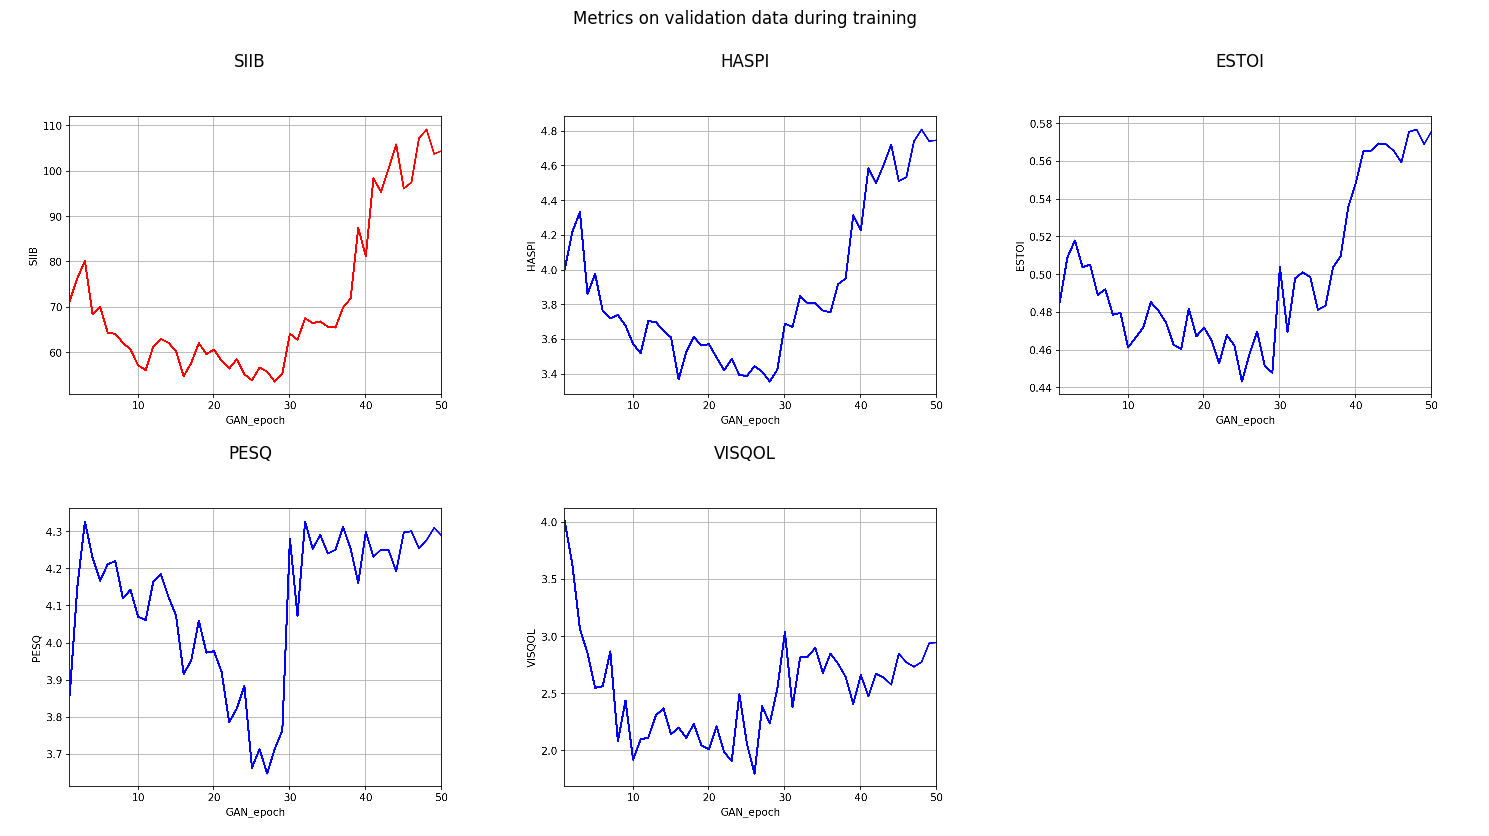

In [13]:
# Display training plots
metrics = ["SIIB", "HASPI", "ESTOI", "PESQ", "VISQOL"]

# Create a new figure
fig = plt.figure()
fig.set_size_inches(15,9)

# Loop through the image files and display each one
for i, metric in enumerate(metrics):
    image_file = f"output/Test_{metric}.png"
    img = imread(image_file)
    ax = fig.add_subplot(2, 3, i + 1)  # 2x3 grid for five images
    ax.imshow(img)
    ax.set_title(metric)
    ax.axis('off')  # Turn off axis labels

fig.suptitle("Metrics on validation data during training")
# Adjust the layout of subplots for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
# Show the figure
plt.show()

# Model Testing

In this section we will compare the performance of the model on the unseen test samples.

As well as including unseen clean samples, this dataset also includes two types of noise not encountered during training or validation.

## Generate enhanced speech on test data

In [14]:
# Set the paths for the test data
Test_Noise_path ='data/Test/Noise/'
Test_Clean_path = 'data/Test/Clean/'
Generator_Test_paths = get_filepaths('data/Test/Clean/')

G = Generator_Conv1D_cLN().cuda()
D = Discriminator().cuda()
MSELoss = nn.MSELoss().cuda()

Test_HASPI = []
Test_ESTOI = []
Test_SIIB = []
Test_PESQ = []
Test_VISQOL = []

# Load the model from the last training epoch
chkpt_path = 'chkpt/chkpt_50.pt'
G.load_state_dict(torch.load(chkpt_path)['enhance-model'])

<All keys matched successfully>

In [ ]:
# Generate the enhanced speech
fs = 16000
p_power = (1/6) # or 0.15
inv_p = 6
Test_enhanced_Name = []
utterance = 0
output_path = "test-enhanced-data"
os.makedirs(output_path, exist_ok=True)
G.eval()
with torch.no_grad():
    for i, path in enumerate(Generator_Test_paths):
        print(i)
        S = path.split('/')
        wave_name = S[-1]

        clean_wav,sr = librosa.load(path, sr=None)
        assert sr==16000
        noise_wav,sr = librosa.load(Test_Noise_path+wave_name, sr=None)
        assert sr==16000

        clean_band, clean_mag, clean_phase = Sp_and_phase_Speech(clean_wav, power=p_power, Normalization=True)
        noise_band, noise_mag, noise_phase = Sp_and_phase_Noise(noise_wav, power=p_power, Normalization=True)
        
        clean_in = clean_band.reshape(1,clean_band.shape[0],-1)
        clean_in = torch.from_numpy(clean_in).cuda()
        noise_in = noise_band.reshape(1,noise_band.shape[0],-1)
        noise_in = torch.from_numpy(noise_in).cuda()
        
        # Energy normalization
        mask = G(clean_in, noise_in)
        clean_power = torch.pow(clean_in, inv_p)

        beta_2 = torch.sum(clean_power) / torch.sum(mask*clean_power)

        mask = mask * beta_2 # normed alpha2
        mask = mask.detach().cpu().squeeze(0).numpy()
        enh_wav = SP_to_wav(mask, clean_mag, clean_phase) # enh_wav has approximately same energy as input, but not strictlly same since calculation error
        enh_wav = enh_wav / rms(enh_wav) * 0.030 # Normalize enh_wav into exactly same energy level as input (here rms is set to 0.03 because we pre-normalized input speech into 0.03 RMS)

        enhanced_name=output_path+"/"+ wave_name[:-4]+'@1.wav'

        sf.write(enhanced_name, enh_wav, fs,'PCM_16')

## Test on the different enhanced signals

In [31]:
def test_enhanced_signals(clean_wav_root, noise_wav_root, enhanced_file_list, noise_type):

    noise_type_filtered_list = [ file for file in enhanced_file_list if noise_type in file ]
    # Calculate True HASPI
    test_HASPI = read_batch_HASPI(clean_wav_root, noise_wav_root, noise_type_filtered_list, norm=False)

    # Calculate True ESTOI
    test_ESTOI = read_batch_STOI(clean_wav_root, noise_wav_root, noise_type_filtered_list, norm=False)

    # Calculate True SIIB
    test_SIIB = read_batch_SIIB(clean_wav_root, noise_wav_root, noise_type_filtered_list, norm=False)

    # Calculate True PESQ
    test_PESQ = read_batch_PESQ(clean_wav_root, noise_type_filtered_list, norm=False)

    # Calculate True VISQOL
    test_VISQOL = read_batch_VISQOL(clean_wav_root, noise_type_filtered_list, norm=False)

    return test_HASPI, test_ESTOI, test_SIIB, test_PESQ, test_VISQOL

In [ ]:
clean_wav_root = "data/Test/Clean/"
noise_wav_root = "data/Test/Noise/"

nele_gan_enhanced_list = [ "test-enhanced-data/"+file for file in os.listdir("test-enhanced-data") ]
wssdrc_enhanced_list = [ "data/Test/MultiEnh/"+file for file in os.listdir("data/Test/MultiEnh") ]
clean_list = [ clean_wav_root+file for file in os.listdir(clean_wav_root) ]


print("Testing NELE-GAN enhanced signals")
cafe_nele_gan_scores = test_enhanced_signals(clean_wav_root, noise_wav_root, nele_gan_enhanced_list, "Cafe")
vacuum_nele_gan_scores = test_enhanced_signals(clean_wav_root, noise_wav_root, nele_gan_enhanced_list, "VacuumCleaner")

print("Testing wSSDRC enhanced signals")
cafe_wssdrc_scores = test_enhanced_signals(clean_wav_root, noise_wav_root, wssdrc_enhanced_list, "Cafe")
vacuum_wssdrc_scores = test_enhanced_signals(clean_wav_root, noise_wav_root, wssdrc_enhanced_list, "VacuumCleaner")

print("Testing clean signals")
cafe_clean_scores = test_enhanced_signals(clean_wav_root, noise_wav_root, clean_list, "Cafe")
vacuum_clean_scores = test_enhanced_signals(clean_wav_root, noise_wav_root, clean_list, "VacuumCleaner")

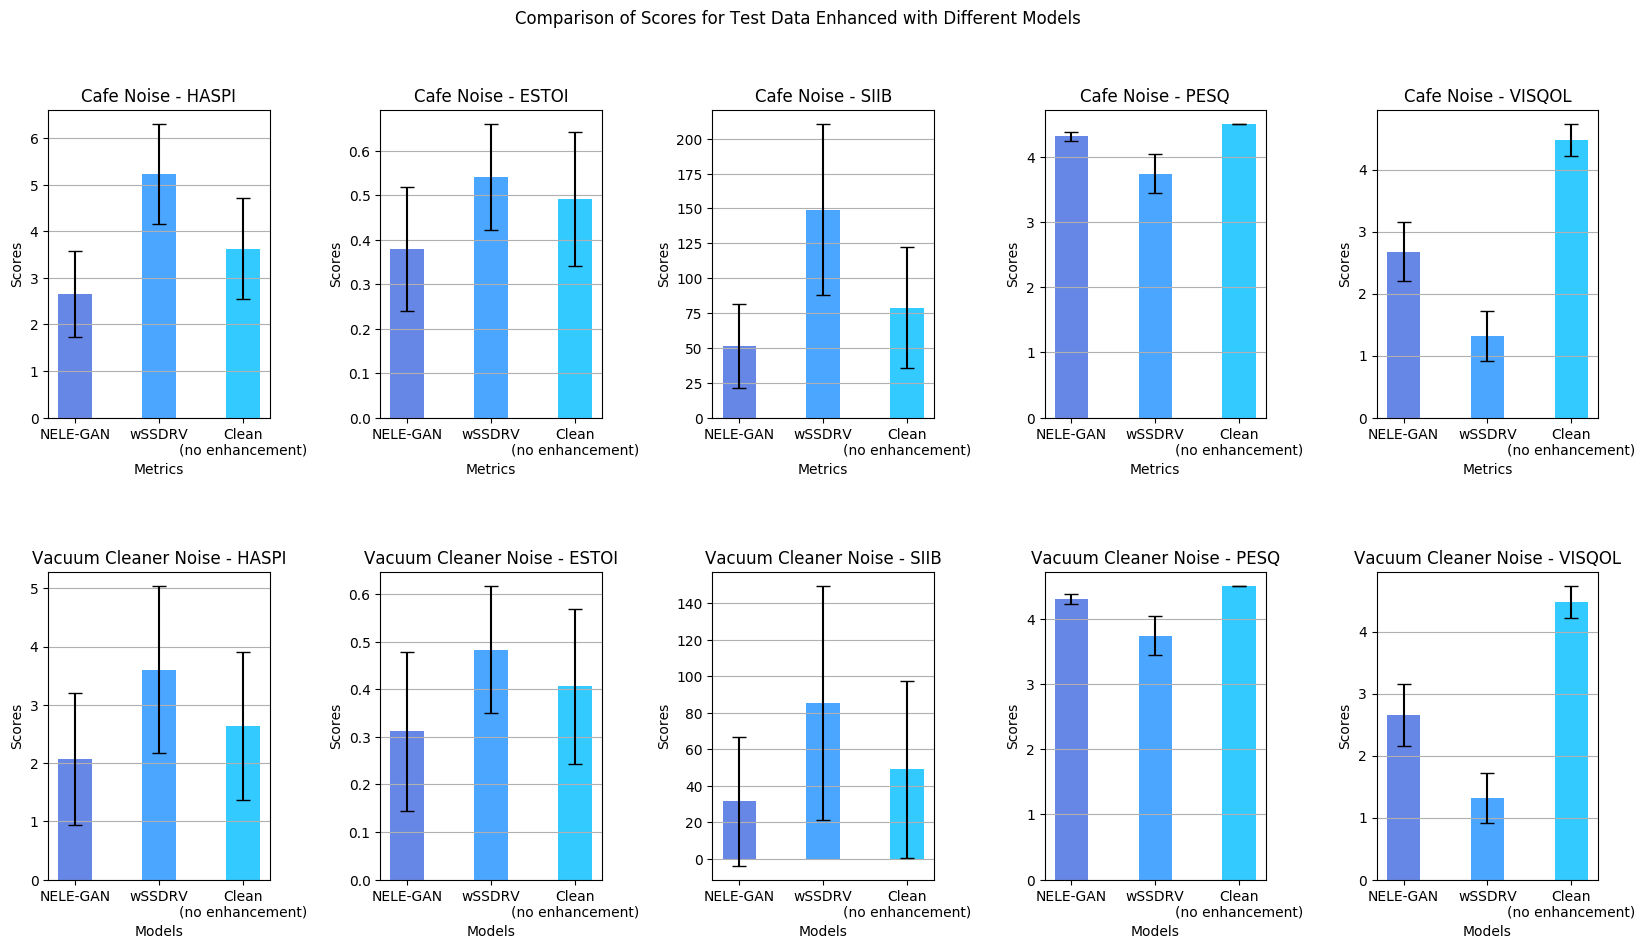

In [70]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ('HASPI', 'ESTOI', 'SIIB', 'PESQ', 'VISQOL')
model_names = ["NELE-GAN", "wSSDRV", "Clean\n(no enhancement)"]

# Number of metrics
num_models = len(model_names)

# Create an array of indices for the x-axis
x = np.arange(num_models)

# Calculate averages and std
cafe_nele_gan_avgs = [np.mean(score) for score in cafe_nele_gan_scores]
cafe_nele_gan_std = [np.std(score) for score in cafe_nele_gan_scores]
cafe_wssdrc_avgs = [np.mean(score) for score in cafe_wssdrc_scores]
cafe_wssdrc_std = [np.std(score) for score in cafe_wssdrc_scores]
cafe_clean_avgs = [np.mean(score) for score in cafe_clean_scores]
cafe_clean_std = [np.std(score) for score in cafe_clean_scores]

vacuum_nele_gan_avgs = [np.mean(score) for score in vacuum_nele_gan_scores]
vacuum_nele_gan_std = [np.std(score) for score in vacuum_nele_gan_scores]
vacuum_wssdrc_avgs = [np.mean(score) for score in vacuum_wssdrc_scores]
vacuum_wssdrc_std = [np.std(score) for score in vacuum_wssdrc_scores]
vacuum_clean_avgs = [np.mean(score) for score in vacuum_clean_scores]
vacuum_clean_std = [np.std(score) for score in vacuum_clean_scores]

# Width of each bar
bar_width = 0.4

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=len(metrics), figsize=(20, 10))

# Create clustered bars for each metric - Cafe Noise
for i, metric in enumerate(metrics):
    axes[0, i].bar(x, [cafe_nele_gan_avgs[i], cafe_wssdrc_avgs[i], cafe_clean_avgs[i]], bar_width, yerr=[cafe_nele_gan_std[i], cafe_wssdrc_std[i], cafe_clean_std[i]], ecolor='black', capsize=5, label='wSSDRC', color=['royalblue', 'dodgerblue', 'deepskyblue'], alpha=0.8)
    # Set the x-axis ticks and labels
    axes[0, i].set_xticks(x)
    axes[0, i].set_xticklabels(model_names)
    axes[0, i].grid(axis='y')
    # Set labels and title
    axes[0, i].set_xlabel('Metrics')
    axes[0, i].set_ylabel('Scores')
    axes[0, i].set_title(f'Cafe Noise - {metric}')

    axes[1, i].bar(x, [vacuum_nele_gan_avgs[i], vacuum_wssdrc_avgs[i], vacuum_clean_avgs[i]], bar_width, yerr=[vacuum_nele_gan_std[i], vacuum_wssdrc_std[i], vacuum_clean_std[i]], ecolor='black', capsize=5, label='wSSDRC', color=['royalblue', 'dodgerblue', 'deepskyblue'], alpha=0.8)
    # Set the x-axis ticks and labels
    axes[1, i].set_xticks(x)
    axes[1, i].set_xticklabels(model_names)
    axes[1, i].grid(axis='y')
    # Set labels and title
    axes[1, i].set_xlabel('Models')
    axes[1, i].set_ylabel('Scores')
    axes[1, i].set_title(f'Vacuum Cleaner Noise - {metric}')

fig.suptitle('Comparison of Scores for Test Data Enhanced with Different Models')

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Display the plot
plt.show()

In [66]:
# Calculate averages and std
cafe_nele_gan_display = [ f"{np.mean(score):0.3f} (std: {np.std(score):0.4f})" for score in cafe_nele_gan_scores ]
cafe_wssdrc_display = [ f"{np.mean(score):0.3f} (std: {np.std(score):0.4f})" for score in cafe_wssdrc_scores ]
cafe_clean_display = [ f"{np.mean(score):0.3f} (std: {np.std(score):0.4f})" for score in cafe_clean_scores ]

vacuum_nele_gan_display = [ f"{np.mean(score):0.3f} (std: {np.std(score):0.4f})" for score in vacuum_nele_gan_scores ]
vacuum_wssdrc_display = [ f"{np.mean(score):0.3f} (std: {np.std(score):0.4f})" for score in vacuum_wssdrc_scores ]
vacuum_clean_display = [ f"{np.mean(score):0.3f} (std: {np.std(score):0.4f})" for score in vacuum_clean_scores ]

model_names = ["NELE-GAN", "wSSDRV", "Clean (no enhancement)"]
metric_names = ('HASPI', 'ESTOI', 'SIIB', 'PESQ', 'VISQOL')

# Generate table for each noise type
cafe_nele_gan_display_values = [  ]
cafe_metric_values = [ cafe_nele_gan_display, cafe_wssdrc_display, cafe_clean_display]
cafe_results_data = [[model] + list(cafe_metrics) for model, cafe_metrics in zip(model_names, cafe_metric_values)]
cafe_results_df = pd.DataFrame(cafe_results_data, columns=["Model Name"] + list(metric_names)).style.hide_index()
display(cafe_results_df)

vacuum_metric_values = [vacuum_nele_gan_display, vacuum_wssdrc_display, vacuum_clean_display]
vacuum_results_data = [[model] + list(vacuum_metrics) for model, vacuum_metrics in zip(model_names, vacuum_metric_values)]
vacuum_results_df = pd.DataFrame(vacuum_results_data, columns=["Model Name"] + list(metric_names)).style.hide_index()
display(vacuum_results_df)

Model Name,HASPI,ESTOI,SIIB,PESQ,VISQOL
NELE-GAN,2.656 (std: 0.9305),0.380 (std: 0.1397),51.180 (std: 30.0261),4.312 (std: 0.0744),2.677 (std: 0.4827)
wSSDRV,5.225 (std: 1.0759),0.541 (std: 0.1191),149.202 (std: 61.2243),3.741 (std: 0.3025),1.313 (std: 0.4087)
Clean (no enhancement),3.627 (std: 1.0862),0.491 (std: 0.1503),78.815 (std: 43.3210),4.500 (std: 0.0000),4.477 (std: 0.2545)


Model Name,HASPI,ESTOI,SIIB,PESQ,VISQOL
NELE-GAN,2.063 (std: 1.1306),0.312 (std: 0.1672),31.471 (std: 35.2158),4.308 (std: 0.0732),2.654 (std: 0.4998)
wSSDRV,3.601 (std: 1.4341),0.483 (std: 0.1337),85.478 (std: 64.3404),3.741 (std: 0.3025),1.313 (std: 0.4087)
Clean (no enhancement),2.633 (std: 1.2645),0.406 (std: 0.1625),49.023 (std: 48.5551),4.500 (std: 0.0000),4.477 (std: 0.2545)


## Generate demonstration samples

In this section we will pick 3 samples from the data and compare the enhancements from the model at different training stages as well as with the other models.

In [51]:
def create_blended_file(file_name, noise_wav_dir):
    
    if "@" in file_name:
        cleaned_file_name = file_name.split("/")[-1].split("@")[0]
    else:
        cleaned_file_name = file_name.split("/")[-1][:-4]

    original_wav, _ = librosa.load(file_name, sr=16000) 
    noise_wav,_ = librosa.load(noise_wav_dir+cleaned_file_name+'.wav', sr=16000)     
    
    # Truncate so waves are the same shape
    minL = min(len(original_wav),len(noise_wav))
    original_wav = original_wav[:minL]
    noise_wav = noise_wav[:minL]

    return original_wav + noise_wav

In [52]:
demo_dir = "demos/epoch_evolution"
os.makedirs(demo_dir, exist_ok=True)
noise_root_dir = 'data/Validation/Noise/'

# Collect samples from different epochs
sample_file_names = ["output/epoch50/Test_epoch50/2428-83699-0024#Munching#-3@50.wav", "output/epoch50/Test_epoch50/1993-147964-0001#NeighborSpeaking#-7@50.wav", "output/epoch50/Test_epoch50/3752-4943-0003#AirConditioner#-7@50.wav",
                     "output/epoch25/Test_epoch25/2428-83699-0024#Munching#-3@25.wav", "output/epoch25/Test_epoch25/1993-147964-0001#NeighborSpeaking#-7@25.wav", "output/epoch25/Test_epoch25/3752-4943-0003#AirConditioner#-7@25.wav",
                     "data/Validation/Clean/2428-83699-0024#Munching#-3.wav", "data/Validation/Clean/1993-147964-0001#NeighborSpeaking#-7.wav", "data/Validation/Clean/3752-4943-0003#AirConditioner#-7.wav"
                     ]
for sample_file in sample_file_names:
    mixed_wav = create_blended_file(sample_file, noise_root_dir)
    mixed_name = os.path.join(demo_dir, sample_file.split("/")[-1])
    sf.write(mixed_name, mixed_wav, 16000,'PCM_16')


In [56]:
demo_dir = "demos/test_data/cafe"
os.makedirs(demo_dir, exist_ok=True)
noise_root_dir = 'data/Test/Noise/'

clean_sample_file_names = ["data/Test/Clean/174-50561-0003#Cafe#-1.wav", "data/Test/Clean/174-50561-0003#Cafe#-5.wav", "data/Test/Clean/174-50561-0003#Cafe#-9.wav"]
wSSDRC_sample_file_names = ["data/Test/MultiEnh/174-50561-0003#Cafe#-1.wav", "data/Test/MultiEnh/174-50561-0003#Cafe#-5.wav", "data/Test/MultiEnh/174-50561-0003#Cafe#-9.wav"]
nele_gan_sample_file_names = ["test-enhanced-data/174-50561-0003#Cafe#-1@1.wav", "test-enhanced-data/174-50561-0003#Cafe#-5@1.wav", "test-enhanced-data/174-50561-0003#Cafe#-9@1.wav"]

for sample_file in clean_sample_file_names:
    mixed_wav = create_blended_file(sample_file, noise_root_dir)
    mixed_name = os.path.join(demo_dir, "clean_"+sample_file.split("/")[-1])
    sf.write(mixed_name, mixed_wav, fs,'PCM_16')

for sample_file in wSSDRC_sample_file_names:
    mixed_wav = create_blended_file(sample_file, noise_root_dir)
    mixed_name = os.path.join(demo_dir, "wSSDRC_"+sample_file.split("/")[-1])
    sf.write(mixed_name, mixed_wav, fs,'PCM_16')

for sample_file in nele_gan_sample_file_names:
    mixed_wav = create_blended_file(sample_file, noise_root_dir)
    mixed_name = os.path.join(demo_dir, "nelegan_"+sample_file.split("/")[-1])
    sf.write(mixed_name, mixed_wav, fs,'PCM_16')

In [59]:
demo_dir = "demos/test_data/vacuum"
os.makedirs(demo_dir, exist_ok=True)
noise_root_dir = 'data/Test/Noise/'

clean_sample_file_names = ["data/Test/Clean/174-50561-0003#VacuumCleaner#-5.wav", "data/Test/Clean/174-50561-0003#VacuumCleaner#-9.wav", "data/Test/Clean/174-50561-0003#VacuumCleaner#-13.wav"]
wSSDRC_sample_file_names = ["data/Test/MultiEnh/174-50561-0003#VacuumCleaner#-5.wav", "data/Test/MultiEnh/174-50561-0003#VacuumCleaner#-9.wav", "data/Test/MultiEnh/174-50561-0003#VacuumCleaner#-13.wav"]
nele_gan_sample_file_names = ["test-enhanced-data/174-50561-0003#VacuumCleaner#-5@1.wav", "test-enhanced-data/174-50561-0003#VacuumCleaner#-9@1.wav", "test-enhanced-data/174-50561-0003#VacuumCleaner#-13@1.wav"]

for sample_file in clean_sample_file_names:
    mixed_wav = create_blended_file(sample_file, noise_root_dir)
    mixed_name = os.path.join(demo_dir, "clean_"+sample_file.split("/")[-1])
    sf.write(mixed_name, mixed_wav, fs,'PCM_16')

for sample_file in wSSDRC_sample_file_names:
    mixed_wav = create_blended_file(sample_file, noise_root_dir)
    mixed_name = os.path.join(demo_dir, "wSSDRC_"+sample_file.split("/")[-1])
    sf.write(mixed_name, mixed_wav, fs,'PCM_16')

for sample_file in nele_gan_sample_file_names:
    mixed_wav = create_blended_file(sample_file, noise_root_dir)
    mixed_name = os.path.join(demo_dir, "nelegan_"+sample_file.split("/")[-1])
    sf.write(mixed_name, mixed_wav, fs,'PCM_16')